In [1]:
from transformers import AutoTokenizer
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ColorJitter, ToTensor, Resize
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from datasets import load_dataset,ClassLabel,Value,concatenate_datasets,Features,Array2D
import matplotlib.pyplot as plt
import numpy as np

/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

dataset_diffusion_train = load_dataset("poloclub/diffusiondb","2m_first_10k")
dataset_diffusion_test = load_dataset("poloclub/diffusiondb","2m_random_5k")
dataset_imagenette = load_dataset("frgfm/imagenette","160px")

Found cached dataset diffusiondb (/home/hakim/.cache/huggingface/datasets/poloclub___diffusiondb/2m_first_10k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1)
100%|██████████| 1/1 [00:00<00:00, 244.39it/s]
Found cached dataset diffusiondb (/home/hakim/.cache/huggingface/datasets/poloclub___diffusiondb/2m_random_5k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1)
100%|██████████| 1/1 [00:00<00:00, 315.76it/s]
Found cached dataset imagenette (/home/hakim/.cache/huggingface/datasets/frgfm___imagenette/160px/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f)
100%|██████████| 2/2 [00:00<00:00, 436.91it/s]


In [3]:
train_db = dataset_diffusion_train["train"].select(range(9469))
val_db = dataset_diffusion_test["train"].select(range(1962))
test_db = dataset_diffusion_test["train"].select(range(1962,3925))

In [4]:
train_I = dataset_imagenette["train"]
val_I = dataset_imagenette["validation"].select(range(1962))
test_I = dataset_imagenette["validation"].select(range(1962,3925)) 

In [5]:
label_column = len(train_db) * [0]
train_db = train_db.add_column("label",label_column)
label_column = len(val_db) * [0]
val_db = val_db.add_column("label",label_column)
label_column = len(test_db) * [0]
test_db = test_db.add_column("label",label_column)

In [6]:
del_col = ['prompt','seed', 'step','cfg','sampler','width','height','user_name','timestamp','image_nsfw', 'prompt_nsfw']
train_db = train_db.remove_columns(del_col)
val_db = val_db.remove_columns(del_col)
test_db = test_db.remove_columns(del_col)

In [7]:
train_I = train_I.remove_columns("label")
val_I = val_I.remove_columns("label")
test_I = test_I.remove_columns("label")

In [8]:
label_column = len(train_I) * [1]
train_I = train_I.add_column("label",label_column)
label_column = len(val_I) * [1]
val_I = val_I.add_column("label",label_column)
label_column = len(test_I) * [1]
test_I = test_I.add_column("label",label_column)

In [9]:
train = concatenate_datasets([train_I,train_db])
val = concatenate_datasets([val_I,val_db])
test = concatenate_datasets([test_I,test_db])

In [10]:
jitter = Compose(
    [ ToTensor(),Resize((160,160))]
)

In [11]:
def transforms(examples):

    examples["pixel_values"] = [jitter(image.convert("RGB")) for image in examples["image"]]

    return examples

In [12]:
train_dataset = train.with_transform(transforms)
val_dataset = val.with_transform(transforms)
test_dataset = train.with_transform(transforms)

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [14]:
def collate_fn(examples):

    images = []

    labels = []

    for example in examples:

        images.append((example["pixel_values"]))

        labels.append(example["label"])

    pixel_values = torch.stack(images)

    labels = torch.tensor(labels)

    return {"pixel_values": pixel_values, "label": labels}

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size)
val_dataloader =  DataLoader(val_dataset, collate_fn=collate_fn, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size)

In [3]:
model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [37]:
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [38]:
tr = model.train()

In [23]:
train_accu = []
train_losses = []

def train(epoch,data):
    print('\nEpoch : %d'%epoch)
    correct = 0
    running_loss=0
    total=0
    for element in data:
        # Move input and label tensors to the device
        inputs = element["pixel_values"].to(device)
        labels = element["label"].to(device)

        # Zero out the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss=running_loss/len(data)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


In [24]:
eval_losses=[]
eval_accu=[]

def val(data):
    correct = 0
    running_loss=0
    total=0
    with torch.no_grad():
      for element in data:
        
          inputs = element["pixel_values"].to(device)
          labels = element["label"].to(device)

        
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

    val_loss=running_loss/len(data)
    accu=100.*correct/total

    eval_accu.append(accu)
    eval_losses.append(val_loss)
    print('Val Loss: %.3f | Accuracy: %.3f'%(val_loss,accu))


In [39]:
epochs=10
for epoch in range(1,epochs+1):
  train(epoch,train_dataloader)
  val(val_dataloader)


Epoch : 1


/home/hakim/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train Loss: 4.520 | Accuracy: 21.718
Val Loss: 2.567 | Accuracy: 40.163

Epoch : 2
Train Loss: 1.030 | Accuracy: 73.038
Val Loss: 1.942 | Accuracy: 48.445

Epoch : 3
Train Loss: 0.595 | Accuracy: 79.987
Val Loss: 1.701 | Accuracy: 49.669

Epoch : 4
Train Loss: 0.471 | Accuracy: 82.517
Val Loss: 1.575 | Accuracy: 49.924

Epoch : 5
Train Loss: 0.414 | Accuracy: 84.127
Val Loss: 1.491 | Accuracy: 50.076

Epoch : 6
Train Loss: 0.379 | Accuracy: 85.125
Val Loss: 1.427 | Accuracy: 50.127

Epoch : 7
Train Loss: 0.354 | Accuracy: 85.806
Val Loss: 1.372 | Accuracy: 50.280

Epoch : 8
Train Loss: 0.334 | Accuracy: 86.572
Val Loss: 1.322 | Accuracy: 50.484

Epoch : 9
Train Loss: 0.318 | Accuracy: 87.179
Val Loss: 1.275 | Accuracy: 50.892

Epoch : 10
Train Loss: 0.302 | Accuracy: 87.707
Val Loss: 1.227 | Accuracy: 51.198


In [40]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for element in test_dataloader:
          # Move input and label tensors to the device
        inputs = element["pixel_values"].to(device)
        labels = element["label"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 50.010560777273206 %


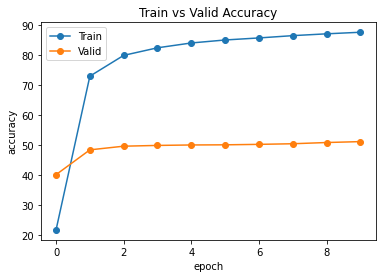

In [42]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

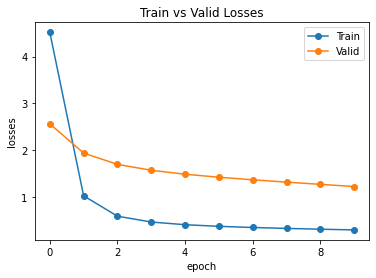

In [43]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [44]:
PATH = './classifier.pth'
torch.save(model.state_dict(), PATH)

In [5]:
from PIL import ImageFile, Image

model.load_state_dict(torch.load("classifier.pth"))
model.to(device)
model.eval()
image = Image.open('t.jpg')
  
transform = Compose([
    ToTensor()
])
  
img_tensor = transform(image)

inputs = img_tensor.to(device)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)

In [6]:
predicted

tensor([0], device='cuda:0')

In [7]:
image = Image.open('test.jpg')
  
transform = Compose([
    ToTensor()
])
  
img_tensor = transform(image)

inputs = img_tensor.to(device)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
predicted

tensor([0], device='cuda:0')

In [8]:
image = Image.open('golf.jpg')
  
transform = Compose([
    ToTensor()
])
  
img_tensor = transform(image)

inputs = img_tensor.to(device)

with torch.no_grad():
    outputs = model(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
predicted

tensor([0], device='cuda:0')